# Inferential Statistics 
Judging from the EDA, it is valuable to conduct inferential statistics to be able to understnad the relationship between our policy holders and the claims rate

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample  # Importing the resample function from sklearn.utils for data resampling
from sklearn.preprocessing import LabelEncoder

In [2]:
#Load our Data 

project_root = Path().resolve().parent  # Moves up one directory from `code/`

# Construct the correct relative path
data_path = project_root / "data" / "Insurance_claims_data.csv"

# Load the dataset
insurance = pd.read_csv(data_path)


In [3]:


# NCAP rating vs. claim status
contingency_table = pd.crosstab(insurance["ncap_rating"], insurance["claim_status"])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test Statistic: {chi2}")
print(f"P-value: {p}")


Chi-Square Test Statistic: 1.4666815737178478
P-value: 0.8325265632423358


In [4]:

# Binning region density into Low, Medium, and High categories
insurance["density_group"] = pd.qcut(insurance["region_density"], q=3, labels=["Low", "Medium", "High"])

# Contingency table: Region Density vs. Claim Status
contingency_table = pd.crosstab(insurance["density_group"], insurance["claim_status"])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test Statistic: {chi2}")
print(f"P-value: {p}")


Chi-Square Test Statistic: 17.61817556790302
P-value: 0.0001493694510200383


In [5]:

# Compare claim rates across different NCAP ratings
anova_result = f_oneway(
    insurance[insurance["ncap_rating"] == 0]["claim_status"],
    insurance[insurance["ncap_rating"] == 2]["claim_status"],
    insurance[insurance["ncap_rating"] == 3]["claim_status"],
    insurance[insurance["ncap_rating"] == 4]["claim_status"],
    insurance[insurance["ncap_rating"] == 5]["claim_status"]
)

print(f"ANOVA Test Statistic: {anova_result.statistic}")
print(f"P-value: {anova_result.pvalue}")


ANOVA Test Statistic: 0.36664828126928556
P-value: 0.8325409643155399


In [6]:

# Select predictor variables
X = insurance[["vehicle_age", "ncap_rating", "airbags", "subscription_length"]]
X = sm.add_constant(X)  # Add intercept term

# Target variable (claim status)
y = insurance["claim_status"]

# Fit logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print summary
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.233666
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           claim_status   No. Observations:                58592
Model:                          Logit   Df Residuals:                    58587
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Feb 2025   Pseudo R-squ.:                 0.01717
Time:                        11:44:54   Log-Likelihood:                -13691.
converged:                       True   LL-Null:                       -13930.
Covariance Type:            nonrobust   LLR p-value:                3.268e-102
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.0586      0.045    -68.165      0.000      -3.147      -2.971
ve

In [7]:
# Check correlation with claim status
insurance[["vehicle_age", "ncap_rating", "airbags", "displacement", "claim_status"]].corr()


,vehicle_age,ncap_rating,airbags,displacement,claim_status
vehicle_age,1.000000,0.348853,0.209073,0.393208,-0.028172
ncap_rating,0.348853,1.000000,0.341557,0.847065,0.003800
airbags,0.209073,0.341557,1.000000,0.661190,0.002789
displacement,0.393208,0.847065,0.661190,1.000000,0.007678
claim_status,-0.028172,0.003800,0.002789,0.007678,1.000000


In [8]:
# Identify categorical features that need encoding
categorical_features = ["is_parking_sensors", "is_tpms", "rear_brakes_type", "steering_type"]

# Convert "Yes"/"No" to 1/0 (Binary Encoding)
for col in categorical_features:
    insurance[col] = insurance[col].map({"Yes": 1, "No": 0})

# One-hot encode categorical variables with multiple categories
insurance = pd.get_dummies(insurance, columns=["fuel_type", "engine_type", "rear_brakes_type"], drop_first=True)


Accuracy: 0.9350627186620019
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10973
           1       0.06      0.00      0.00       746

    accuracy                           0.94     11719
   macro avg       0.50      0.50      0.48     11719
weighted avg       0.88      0.94      0.91     11719



/Users/admin/.pyenv/versions/3.11.0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/admin/.pyenv/versions/3.11.0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/admin/.pyenv/versions/3.11.0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


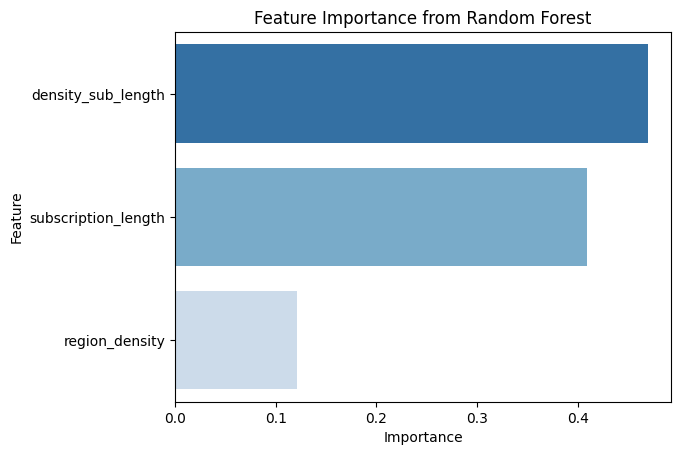

In [10]:
insurance["density_sub_length"] = insurance["region_density"] * insurance["subscription_length"]

# Select features for Random Forest
features = ["subscription_length", "region_density", "density_sub_length"]
X = insurance[features]
y = insurance["claim_status"]

# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance plot


feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="Blues_r")
plt.title("Feature Importance from Random Forest")
plt.show()


In [12]:
import numpy as np
import scipy.stats as stats
import pandas as pd

# Define significance level (alpha)
alpha = 0.05

# Define the hypotheses:
# H0: The feature does not impact claim likelihood (mean difference = 0)
# Ha: The feature impacts claim likelihood (mean difference ≠ 0)

# 1️⃣ Degrees of Freedom (df)
n_claims = len(insurance[insurance["claim_status"] == 1])
n_no_claims = len(insurance[insurance["claim_status"] == 0])
df_claims = n_claims - 1
df_no_claims = n_no_claims - 1

print(f"Degrees of Freedom (Claims): {df_claims}")
print(f"Degrees of Freedom (No Claims): {df_no_claims}")

# 2️⃣ Compute Sample Statistics
features = ["subscription_length", "region_density", "vehicle_age"]
results = {}

for feature in features:
    # Separate the data into two groups: claims (1) and no claims (0)
    claims = insurance[insurance["claim_status"] == 1][feature]
    no_claims = insurance[insurance["claim_status"] == 0][feature]

    # Compute mean and standard deviation for each group
    mean_claims = claims.mean()
    mean_no_claims = no_claims.mean()
    std_claims = claims.std()
    std_no_claims = no_claims.std()

    # Compute standard error of the mean (SEM)
    SEM_claims = std_claims / np.sqrt(n_claims)
    SEM_no_claims = std_no_claims / np.sqrt(n_no_claims)

    # Compute the t-statistic
    t_stat, p_value = stats.ttest_ind(claims, no_claims, equal_var=False)  # Welch's t-test

    # Compute confidence interval
    t_critical = stats.t.ppf(1 - alpha/2, min(df_claims, df_no_claims))  # Two-tailed test
    ME = t_critical * SEM_claims  # Margin of error
    confidence_interval = (mean_claims - ME, mean_claims + ME)

    # Store results
    results[feature] = {
        "Mean (Claims)": mean_claims,
        "Mean (No Claims)": mean_no_claims,
        "Std Dev (Claims)": std_claims,
        "Std Dev (No Claims)": std_no_claims,
        "T-Statistic": t_stat,
        "P-Value": p_value,
        "Confidence Interval": confidence_interval
    }

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results).T
print(results_df)


Degrees of Freedom (Claims): 3747
Degrees of Freedom (No Claims): 54843
                    Mean (Claims) Mean (No Claims) Std Dev (Claims)  \
subscription_length      7.359472         6.026415         3.892442   
region_density       17623.820438     18909.073445     16130.125259   
vehicle_age              1.266222         1.396827         1.061162   

                    Std Dev (No Claims) T-Statistic   P-Value  \
subscription_length            4.145695   20.198232       0.0   
region_density             17757.086238   -4.687836  0.000003   
vehicle_age                    1.138777   -7.254851       0.0   

                                          Confidence Interval  
subscription_length   (7.2348164104850925, 7.484127026014373)  
region_density       (17107.253806316636, 18140.387068816766)  
vehicle_age          (1.2322383177572698, 1.3002056523601262)  
